## Origin

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

env_name = 'CartPole-v1'
gamma = 0.99
goal_score = 200
log_interval = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_kl = 0.01

def flat_grad(grads):
    grad_flatten = []
    for grad in grads:
        grad_flatten.append(grad.view(-1))
    grad_flatten = torch.cat(grad_flatten)
    return grad_flatten

def flat_hessian(hessians):
    hessians_flatten = []
    for hessian in hessians:
        hessians_flatten.append(hessian.contiguous().view(-1))
    hessians_flatten = torch.cat(hessians_flatten).data
    return hessians_flatten

def flat_params(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))
    params_flatten = torch.cat(params)
    return params_flatten

def update_model(model, new_params):
    index = 0
    for params in model.parameters():
        torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
        params_length = len(params.view(-1))
        new_param = new_params[index: index + params_length]
        new_param = new_param.view(params.size())
        params.data.copy_(new_param)
        index += params_length

def kl_divergence(policy, old_policy):
    kl = old_policy * torch.log(old_policy / policy)

    kl = kl.sum(1, keepdim=True)
    return kl

def fisher_vector_product(net, states, p, cg_damp=0.1):
    policy = net(states)
    old_policy = net(states).detach()
    kl = kl_divergence(policy, old_policy)
    kl = kl.mean()
    kl_grad = torch.autograd.grad(kl, net.parameters(), create_graph=True) # create_graph is True if we need higher order derivative products
    kl_grad = flat_grad(kl_grad)

    kl_grad_p = (kl_grad * p.detach()).sum()
    kl_hessian_p = torch.autograd.grad(kl_grad_p, net.parameters())
    kl_hessian_p = flat_hessian(kl_hessian_p)

    return kl_hessian_p + cg_damp * p.detach()


def conjugate_gradient(net, states, loss_grad, n_step=10, residual_tol=1e-10):
    x = torch.zeros(loss_grad.size())
    r = loss_grad.clone()
    p = loss_grad.clone()
    r_dot_r = torch.dot(r, r)

    for i in range(n_step):
        A_dot_p = fisher_vector_product(net, states, p)
        alpha = r_dot_r / torch.dot(p, A_dot_p)
        x += alpha * p
        r -= alpha * A_dot_p
        new_r_dot_r = torch.dot(r,r)
        betta = new_r_dot_r / r_dot_r
        p = r + betta * p
        r_dot_r = new_r_dot_r
        if r_dot_r < residual_tol:
            break
    return x

class TRPO(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(TRPO, self).__init__()
        self.t = 0
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc_1 = nn.Linear(num_inputs, 128)
        self.fc_2 = nn.Linear(128, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)

    def forward(self, input):
        x = torch.relu(self.fc_1(input))
        policy = F.softmax(self.fc_2(x))

        return policy

    @classmethod
    def train_model(cls, net, transitions):
        states, actions, rewards, masks = transitions.state, transitions.action, transitions.reward, transitions.mask

        states = torch.stack(states)
        actions = torch.stack(actions)
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)

        returns = torch.zeros_like(rewards)

        running_return = 0
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + gamma * running_return * masks[t]
            returns[t] = running_return

        policy = net(states)
        policy = policy.view(-1, net.num_outputs)
        policy_action = (policy * actions.detach()).sum(dim=1)

        old_policy = net(states).detach()
        old_policy = old_policy.view(-1, net.num_outputs)
        old_policy_action = (old_policy * actions.detach()).sum(dim=1)

        surrogate_loss = ((policy_action / old_policy_action) * returns).mean()

        surrogate_loss_grad = torch.autograd.grad(surrogate_loss, net.parameters())
        surrogate_loss_grad = flat_grad(surrogate_loss_grad)

        step_dir = conjugate_gradient(net, states, surrogate_loss_grad.data)

        params = flat_params(net)
        shs = (step_dir * fisher_vector_product(net, states, step_dir)).sum(0, keepdim=True)
        step_size = torch.sqrt((2 * max_kl) / shs)[0]
        full_step = step_size * step_dir

        fraction = 1.0
        for _ in range(10):
            new_params = params + fraction * full_step
            update_model(net, new_params)
            policy = net(states)
            policy = policy.view(-1, net.num_outputs)
            policy_action = (policy * actions.detach()).sum(dim=1)
            surrogate_loss = ((policy_action / old_policy_action) * returns).mean()

            kl = kl_divergence(policy, old_policy)
            kl = kl.mean()

            if kl < max_kl:
                break
            fraction = fraction * 0.5

        return -surrogate_loss

    def get_action(self, input):
        policy = self.forward(input)
        policy = policy[0].data.numpy()

        action = np.random.choice(self.num_outputs, 1, p=policy)[0]
        return action

In [8]:
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))

class Memory(object):
    def __init__(self):
        self.memory = deque()

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))

    def sample(self):
        memory = self.memory
        return Transition(*zip(*memory))

    def __len__(self):
        return len(self.memory)

In [9]:
import os
import sys
import gym
import random
import numpy as np

import torch
import torch.optim as optim
import torch.nn.functional as F
from tensorboardX import SummaryWriter


def main():
    env = gym.make(env_name)
    env.seed(500)
    torch.manual_seed(500)

    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.n
    print('state size:', num_inputs)
    print('action size:', num_actions)

    net = TRPO(num_inputs, num_actions)
    writer = SummaryWriter('logs')

    net.to(device)
    net.train()
    running_score = 0
    steps = 0
    loss = 0
    for e in range(100):
        done = False
        memory = Memory()

        score = 0
        state = env.reset()
        state = torch.Tensor(state).to(device)
        state = state.unsqueeze(0)

        while not done:
            steps += 1

            action = net.get_action(state)
            next_state, reward, done, _ = env.step(action)

            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)

            mask = 0 if done else 1
            reward = reward if not done or score == 499 else -1

            action_one_hot = torch.zeros(2)
            action_one_hot[action] = 1
            memory.push(state, next_state, action_one_hot, reward, mask)

            score += reward
            state = next_state

        loss = TRPO.train_model(net, memory.sample())

        score = score if score == 500.0 else score + 1
        running_score = 0.99 * running_score + 0.01 * score
        if e % log_interval == 0:
            print('{} episode | score: {:.2f}'.format(
                e, running_score))
            writer.add_scalar('log/score', float(running_score), e)
            writer.add_scalar('log/loss', float(loss), e)

        if running_score > goal_score:
            break


if __name__=="__main__":
    main()

ModuleNotFoundError: No module named 'tensorboardX'

## CP - Try 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

gamma = 0.99
goal_score = 200
log_interval = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_kl = 0.01

def flat_grad(grads):
    grad_flatten = []
    for grad in grads:
        grad_flatten.append(grad.view(-1))
    grad_flatten = torch.cat(grad_flatten)
    return grad_flatten

def flat_hessian(hessians):
    hessians_flatten = []
    for hessian in hessians:
        hessians_flatten.append(hessian.contiguous().view(-1))
    hessians_flatten = torch.cat(hessians_flatten).data
    return hessians_flatten

def flat_params(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))
    params_flatten = torch.cat(params)
    return params_flatten

def update_model(model, new_params):
    index = 0
    for params in model.parameters():
        params_length = len(params.view(-1))
        new_param = new_params[index: index + params_length]
        new_param = new_param.view(params.size())
        params.data.copy_(new_param)
        index += params_length

def kl_divergence(policy, old_policy):
    kl = old_policy * torch.log(old_policy / policy)

    kl = kl.sum(1, keepdim=True)
    return kl

def fisher_vector_product(net, states, p, cg_damp=0.1):
    policy = net(states)
    old_policy = net(states).detach()
    kl = kl_divergence(policy, old_policy)
    kl = kl.mean()
    kl_grad = torch.autograd.grad(kl, net.parameters(), create_graph=True) # create_graph is True if we need higher order derivative products
    kl_grad = flat_grad(kl_grad)

    kl_grad_p = (kl_grad * p.detach()).sum()
    kl_hessian_p = torch.autograd.grad(kl_grad_p, net.parameters())
    kl_hessian_p = flat_hessian(kl_hessian_p)

    return kl_hessian_p + cg_damp * p.detach()


def conjugate_gradient(net, states, loss_grad, n_step=10, residual_tol=1e-10):
    x = torch.zeros(loss_grad.size())
    r = loss_grad.clone()
    p = loss_grad.clone()
    r_dot_r = torch.dot(r, r)

    for i in range(n_step):
        A_dot_p = fisher_vector_product(net, states, p)
        alpha = r_dot_r / torch.dot(p, A_dot_p)
        x += alpha * p
        r -= alpha * A_dot_p
        new_r_dot_r = torch.dot(r,r)
        betta = new_r_dot_r / r_dot_r
        p = r + betta * p
        r_dot_r = new_r_dot_r
        if r_dot_r < residual_tol:
            break
    return x

class TRPO(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(TRPO, self).__init__()
        self.t = 0
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc_1 = nn.Linear(num_inputs, 128)
        self.fc_2 = nn.Linear(128, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)

    def forward(self, input):
        x = torch.relu(self.fc_1(input))
        policy = F.softmax(self.fc_2(x))

        return policy

    @classmethod
    def train_model(cls, net, transitions):
        states, actions, rewards, masks = transitions.state, transitions.action, transitions.reward, transitions.mask

        states = torch.stack(states)
        actions = torch.stack(actions)
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)

        returns = torch.zeros_like(rewards)

        running_return = 0
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + gamma * running_return * masks[t]
            returns[t] = running_return

        policy = net(states)
        policy = policy.view(-1, net.num_outputs)
        policy_action = (policy * actions.detach()).sum(dim=1)

        old_policy = net(states).detach()
        old_policy = old_policy.view(-1, net.num_outputs)
        old_policy_action = (old_policy * actions.detach()).sum(dim=1)

        surrogate_loss = ((policy_action / old_policy_action) * returns).mean()

        surrogate_loss_grad = torch.autograd.grad(surrogate_loss, net.parameters())
        surrogate_loss_grad = flat_grad(surrogate_loss_grad)

        step_dir = conjugate_gradient(net, states, surrogate_loss_grad.data)

        params = flat_params(net)
        shs = (step_dir * fisher_vector_product(net, states, step_dir)).sum(0, keepdim=True)
        step_size = torch.sqrt((2 * max_kl) / shs)[0]
        full_step = step_size * step_dir

        fraction = 1.0
        for _ in range(10):
            new_params = params + fraction * full_step
            update_model(net, new_params)
            policy = net(states)
            policy = policy.view(-1, net.num_outputs)
            policy_action = (policy * actions.detach()).sum(dim=1)
            surrogate_loss = ((policy_action / old_policy_action) * returns).mean()

            kl = kl_divergence(policy, old_policy)
            kl = kl.mean()

            if kl < max_kl:
                break
            fraction = fraction * 0.5

        return -surrogate_loss

    def get_action(self, input):
        policy = self.forward(input)
        policy = policy[0].data.numpy()

        action = np.random.choice(self.num_outputs, 1, p=policy)[0]
        return action

import random
from collections import namedtuple, deque

Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))

class Memory(object):
    def __init__(self):
        self.memory = deque()

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))

    def sample(self):
        memory = self.memory
        return Transition(*zip(*memory))

    def __len__(self):
        return len(self.memory)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
<ipython-input-1-eae9cacfc7be>:95: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)
<ipython-in

state size: 4
action size: 2
0 episode | score: 0.22
10 episode | score: 3.97
20 episode | score: 7.04
30 episode | score: 10.85
40 episode | score: 13.13
50 episode | score: 15.92
60 episode | score: 17.50
70 episode | score: 20.36
80 episode | score: 22.72
90 episode | score: 23.54
100 episode | score: 25.06
110 episode | score: 26.65
120 episode | score: 28.46
130 episode | score: 31.42
140 episode | score: 34.41
150 episode | score: 38.92
160 episode | score: 47.43
170 episode | score: 51.84
180 episode | score: 55.16
190 episode | score: 58.82
200 episode | score: 63.40
210 episode | score: 67.51
220 episode | score: 81.78
230 episode | score: 86.18
240 episode | score: 88.18
250 episode | score: 90.64
260 episode | score: 104.27
270 episode | score: 113.02
280 episode | score: 123.19
290 episode | score: 130.04
300 episode | score: 141.44
310 episode | score: 147.50
320 episode | score: 155.92
330 episode | score: 164.92
340 episode | score: 169.83
350 episode | score: 180.20
360

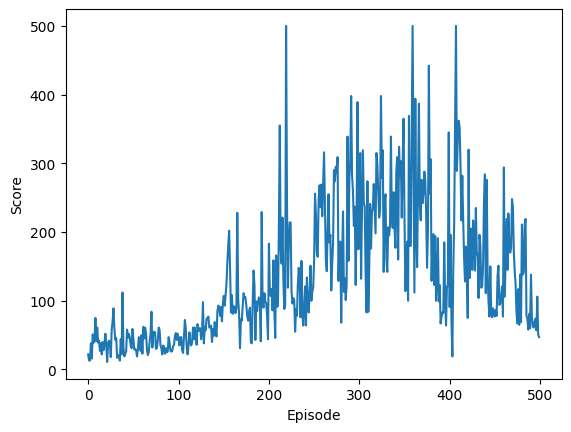

In [ ]:
import matplotlib.pyplot as plt
import gym
def main():
    env = gym.make('CartPole-v1')
    env.seed(500)
    torch.manual_seed(500)

    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.n
    print('state size:', num_inputs)
    print('action size:', num_actions)

    net = TRPO(num_inputs, num_actions)

    net.to(device)
    net.train()
    running_score = 0
    steps = 0
    loss = 0

    # Create lists to hold scores and episodes
    scores = []
    episodes = []

    for e in range(500):
        done = False
        memory = Memory()

        score = 0
        state = env.reset()
        state = torch.Tensor(state).to(device)
        state = state.unsqueeze(0)

        while not done:
            steps += 1

            action = net.get_action(state)
            next_state, reward, done, _ = env.step(action)

            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)

            mask = 0 if done else 1
            reward = reward if not done or score == 499 else -1

            action_one_hot = torch.zeros(2)
            action_one_hot[action] = 1
            memory.push(state, next_state, action_one_hot, reward, mask)

            score += reward
            state = next_state

        loss = TRPO.train_model(net, memory.sample())

        score = score if score == 500.0 else score + 1
        running_score = 0.99 * running_score + 0.01 * score

        # Append score and episode number to lists
        scores.append(score)
        episodes.append(e)

        if e % log_interval == 0:
            print('{} episode | score: {:.2f}'.format(e, running_score))

        if running_score > goal_score:
            break

    # After all episodes, plot the scores
    plt.plot(episodes, scores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()

if __name__=="__main__":
    main()


## MC - Try 1

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Makes gradient of function loss_fn wrt var_list and
# flattens it to have a 1-D vector
def flatgrad(loss_fn, var_list):
	with tf.GradientTape() as t:
		loss = loss_fn()
	grads = t.gradient(loss, var_list, unconnected_gradients=tf.UnconnectedGradients.ZERO)
	return tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)

def nn_model(input_shape, output_shape, convolutional=False):
	model = keras.Sequential()
	if convolutional:
		model.add(layers.Lambda(lambda x: tf.cast(tf.image.resize(tf.image.rgb_to_grayscale(x), size=(32,32)), dtype=tf.float64)/256., input_shape=input_shape))
		model.add(layers.Conv2D(10, (3, 3), activation='relu'))
		model.add(layers.MaxPooling2D((3, 3)))
		model.add(layers.Conv2D(5, (3, 3), activation='relu'))
		model.add(layers.MaxPooling2D((3, 3)))
		model.add(layers.Flatten())
	# else:
	model.add(layers.Dense(64, input_shape=input_shape, activation='relu'))
	model.add(layers.Dense(64, activation='relu'))
	model.add(layers.Dense(output_shape))
	return model

def nn_model2(input_shape, output_shape, convolutional=False):
	model = keras.Sequential()
	if convolutional:
		model.add(layers.Lambda(lambda x: tf.cast(tf.image.resize(tf.image.rgb_to_grayscale(tf.image.crop_to_bounding_box(x, 33,0,160,160)), size=(32,32)), dtype=tf.float64)/256., input_shape=input_shape))
		model.add(layers.Conv2D(20, (3, 3), activation='relu'))
		model.add(layers.MaxPooling2D((3, 3)))
		model.add(layers.Conv2D(20, (3, 3), activation='relu'))
		model.add(layers.MaxPooling2D((3, 3)))
		model.add(layers.Flatten())
	# else:
	model.add(layers.Dense(128, input_shape=input_shape, activation='relu'))
	model.add(layers.Dense(64, activation='relu'))
	model.add(layers.Dense(output_shape))
	return model


def assign_vars(model, theta):
		"""
		Create the process of assigning updated vars
		"""
		shapes = [v.shape.as_list() for v in model.trainable_variables]
		size_theta = np.sum([np.prod(shape) for shape in shapes])
		# self.assign_weights_op = tf.assign(self.flat_weights, self.flat_wieghts_ph)
		start = 0
		for i, shape in enumerate(shapes):
			size = np.prod(shape)
			param = tf.reshape(theta[start:start + size], shape)
			model.trainable_variables[i].assign(param)
			start += size
		assert start == size_theta, "messy shapes"

def flatvars(model):
	return tf.concat([tf.reshape(v, [-1]) for v in model.trainable_variables], axis=0)

if __name__ == '__main__':
	model = nn_model((3,1), 4)

	model.summary()

	fv = flatvars(model).numpy()

	assign_vars(model, fv)

	fv_new = flatvars(model).numpy()

	print((fv == fv_new).all())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3, 64)             128       
                                                                 
 dense_1 (Dense)             (None, 3, 64)             4160      
                                                                 
 dense_2 (Dense)             (None, 3, 4)              260       
                                                                 
Total params: 4548 (17.77 KB)
Trainable params: 4548 (17.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
True


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, models
import numpy as np
import os
import glob
from datetime import datetime
import threading
import gym
import time
import copy

class TRPO:
	def __init__(self, env_name, env, policy_model, value_model=None, value_lr=1e-1, gamma=0.99, delta = 0.01,
				cg_damping=0.001, cg_iters=10, residual_tol=1e-5, ent_coeff=0.0, epsilon=0.4,
				backtrack_coeff=0.6, backtrack_iters=10, render=False, batch_size=4096, n_paths=10, n_threads=2, epsilon_decay=lambda x: x - 5e-3, reward_scaling = 1., correlated_epsilon=False):
		self.env_name = env_name
		self.N_PATHS = n_paths
		self.N_THREADS = n_threads
		self.envs = []
		self.epsilon_decay = epsilon_decay
		assert self.N_PATHS > 0 and self.N_THREADS > 0
		for i in range(self.N_PATHS):
			self.envs.append(copy.deepcopy(env))
		self.gamma = gamma
		self.cg_iters = cg_iters
		self.cg_damping = cg_damping
		self.ent_coeff = ent_coeff
		self.residual_tol = residual_tol
		current_time = datetime.now().strftime('%b%d_%H-%M-%S')
		self.name = f"mylogs/TRPO-{self.env_name}-{current_time}"
		self.model = policy_model
		self.tmp_model = models.clone_model(self.model)
		self.value_model = value_model
		if self.value_model:
			self.value_optimizer = optimizers.Adam(lr=value_lr)
			self.value_model.compile(self.value_optimizer, "mse")
			self.writer = tf.summary.create_file_writer(self.name)
		self.delta = delta
		self.epsilon = epsilon
		self.backtrack_coeff = backtrack_coeff
		self.backtrack_iters = backtrack_iters
		self.render = render
		self.reward_scaling = reward_scaling
		self.correlated_epsilon = correlated_epsilon
		if render:
			os.system("touch render")
		elif not render and len(glob.glob("render")) > 0:
			os.system("rm render")
		self.BATCH_SIZE = batch_size
	def close(self):
		for env in self.envs:
			env.close()
	def __call__(self, ob, last_action=None):
		ob = ob[np.newaxis, :]
		logits = self.model(ob)
		action_prob = tf.nn.softmax(logits).numpy().ravel()
		action = np.random.choice(range(action_prob.shape[0]), p=action_prob)
		# epsilon greedy
		if np.random.uniform(0,1) < self.epsilon:
			if self.correlated_epsilon and np.random.uniform(0,1) < 0.8 and last_action is not None:
				action = last_action
			else:
				action = np.random.randint(0,self.envs[0].action_space.n)
		self.last_action = action
		return action, action_prob
	def render_episode(self, n=1):
		for i in range(n):
			ob = self.envs[0].reset()
			done = False
			action = None
			while not done:
				self.envs[0].render()
				action, _ = self(ob, action)
				ob, r, done, info = self.envs[0].step(action)

	def load_weights(self, path):
		self.model.load_weights(path)

	def sample(self, episode):
		obs_all, actions_all, rs_all, action_probs_all, Gs_all = [None]*self.N_PATHS, [None]*self.N_PATHS, [None]*self.N_PATHS, [None]*self.N_PATHS, [None]*self.N_PATHS
		mean_total_reward = [None]*self.N_PATHS
		mean_entropy = [None]*self.N_PATHS
		if len(glob.glob("render")) > 0:
			self.render = True
		else:
			self.render = False

		if self.render:
			self.render_episode()

		def generate_path(path):
			entropy = 0
			obs, actions, rs, action_probs, Gs = [], [], [], [], []
			ob = self.envs[path].reset()
			done = False

			last_action = None
			while not done:
				action, action_prob = self(ob, last_action)
				new_ob, r, done, info = self.envs[path].step(action)
				last_action = action
				rs.append(r/self.reward_scaling)
				obs.append(ob)
				actions.append(action)
				action_probs.append(action_prob)
				entropy += - tf.reduce_sum(action_prob*tf.math.log(action_prob))
				ob = new_ob
			G = 0
			for r in rs[::-1]:
				G = r + self.gamma*G
				Gs.insert(0, G)
			mean_total_reward[path] = sum(rs)
			entropy = entropy / len(actions)
			mean_entropy[path] = entropy
			obs_all[path] = obs
			actions_all[path] = actions
			rs_all[path] = rs
			action_probs_all[path] = action_probs
			Gs_all[path] = Gs

		i = 0
		while i < self.N_PATHS:
			j = 0
			threads = []
			while j < self.N_THREADS and i < self.N_PATHS:
				thread = threading.Thread(target=generate_path, args=(i,))
				thread.start()
				threads.append(thread)
				j += 1
				i += 1
			for thread in threads:
				thread.join()


		mean_entropy = np.mean(mean_entropy)
		best_reward = np.max(mean_total_reward)
		mean_total_reward = np.mean(mean_total_reward)
		Gs_all = np.concatenate(Gs_all)
		obs_all = np.concatenate(obs_all)
		rs_all = np.concatenate(rs_all)
		actions_all = np.concatenate(actions_all)
		action_probs_all = np.concatenate(action_probs_all)
		return obs_all, Gs_all, mean_total_reward, best_reward, actions_all, action_probs_all, mean_entropy

	def train_step(self, episode, obs_all, Gs_all, actions_all, action_probs_all, total_reward, best_reward, entropy, t0):
		def surrogate_loss(theta=None):
			if theta is None:
				model = self.model
			else:
				model = self.tmp_model
				assign_vars(self.tmp_model, theta)
			logits = model(obs)
			action_prob = tf.nn.softmax(logits)
			action_prob = tf.reduce_sum(actions_one_hot * action_prob, axis=1)
			old_logits = self.model(obs)
			old_action_prob = tf.nn.softmax(old_logits)
			old_action_prob = tf.reduce_sum(actions_one_hot * old_action_prob, axis=1).numpy() + 1e-8
			prob_ratio = action_prob / old_action_prob # pi(a|s) / pi_old(a|s)
			loss = tf.reduce_mean(prob_ratio * advantage) + self.ent_coeff * entropy
			return loss

		def kl_fn(theta=None):
			if theta is None:
				model = self.model
			else:
				model = self.tmp_model
				assign_vars(self.tmp_model, theta)
			logits = model(obs)
			action_prob = tf.nn.softmax(logits).numpy() + 1e-8
			old_logits = self.model(obs)
			old_action_prob = tf.nn.softmax(old_logits)
			return tf.reduce_mean(tf.reduce_sum(old_action_prob * tf.math.log(old_action_prob / action_prob), axis=1))

		def hessian_vector_product(p):
			def hvp_fn():
				kl_grad_vector = flatgrad(kl_fn, self.model.trainable_variables)
				grad_vector_product = tf.reduce_sum(kl_grad_vector * p)
				return grad_vector_product

			fisher_vector_product = flatgrad(hvp_fn, self.model.trainable_variables).numpy()
			return fisher_vector_product + (self.cg_damping * p)

		def conjugate_grad(Ax, b):
			"""
			Conjugate gradient algorithm
			(see https://en.wikipedia.org/wiki/Conjugate_gradient_method)
			"""
			x = np.zeros_like(b)
			r = b.copy() # Note: should be 'b - Ax(x)', but for x=0, Ax(x)=0. Change if doing warm start.
			p = r.copy()
			old_p = p.copy()
			r_dot_old = np.dot(r,r)
			for _ in range(self.cg_iters):
				z = Ax(p)
				alpha = r_dot_old / (np.dot(p, z) + 1e-8)
				old_x = x
				x += alpha * p
				r -= alpha * z
				r_dot_new = np.dot(r,r)
				beta = r_dot_new / (r_dot_old + 1e-8)
				r_dot_old = r_dot_new
				if r_dot_old < self.residual_tol:
					break
				old_p = p.copy()
				p = r + beta * p
				if np.isnan(x).any():
					print("x is nan")
					print("z", np.isnan(z))
					print("old_x", np.isnan(old_x))
					print("kl_fn", np.isnan(kl_fn()))
			return x

		def linesearch(x, fullstep):
			fval = surrogate_loss(x)
			for (_n_backtracks, stepfrac) in enumerate(self.backtrack_coeff**np.arange(self.backtrack_iters)):
				xnew = x + stepfrac * fullstep
				newfval = surrogate_loss(xnew)
				kl_div = kl_fn(xnew)
				if np.isnan(kl_div):
					print("kl is nan")
					print("xnew", np.isnan(xnew))
					print("x", np.isnan(x))
					print("stepfrac", np.isnan(stepfrac))
					print("fullstep",  np.isnan(fullstep))
				if kl_div <= self.delta and newfval >= 0:
					print("Linesearch worked at ", _n_backtracks)
					return xnew
				if _n_backtracks == self.backtrack_iters - 1:
					print("Linesearch failed.", kl_div, newfval)
			return x

		NBATCHES = len(obs_all) // self.BATCH_SIZE
		if len(obs_all) < self.BATCH_SIZE:
			NBATCHES += 1
		for batch_id in range(NBATCHES):
			obs = obs_all[batch_id*self.BATCH_SIZE: (batch_id + 1)*self.BATCH_SIZE]
			Gs = Gs_all[batch_id*self.BATCH_SIZE: (batch_id + 1)*self.BATCH_SIZE]
			actions = actions_all[batch_id*self.BATCH_SIZE: (batch_id + 1)*self.BATCH_SIZE]
			action_probs = action_probs_all[batch_id*self.BATCH_SIZE: (batch_id + 1)*self.BATCH_SIZE]


			Vs = self.value_model(obs).numpy().flatten()
			# advantage = Gs
			advantage = Gs - Vs
			advantage = (advantage - advantage.mean())/(advantage.std() + 1e-8)
			actions_one_hot = tf.one_hot(actions, self.envs[0].action_space.n, dtype="float64")
			policy_loss = surrogate_loss()
			policy_gradient = flatgrad(surrogate_loss, self.model.trainable_variables).numpy()




			step_direction = conjugate_grad(hessian_vector_product, policy_gradient)

			shs = .5 * step_direction.dot(hessian_vector_product(step_direction).T)

			lm = np.sqrt(shs / self.delta) + 1e-8
			fullstep = step_direction / lm
			if np.isnan(fullstep).any():
				print("fullstep is nan")
				print("lm", lm)
				print("step_direction", step_direction)
				print("policy_gradient", policy_gradient)

			oldtheta = flatvars(self.model).numpy()

			theta = linesearch(oldtheta, fullstep)


			if np.isnan(theta).any():
				print("NaN detected. Skipping update...")
			else:
				assign_vars(self.model, theta)

			kl = kl_fn(oldtheta)

			history = self.value_model.fit(obs, Gs, epochs=5, verbose=0)
			value_loss = history.history["loss"][-1]


			print(f"Ep {episode}.{batch_id}: Rw_mean {total_reward} - Rw_best {best_reward} - PL {policy_loss} - VL {value_loss} - KL {kl} - epsilon {self.epsilon} - time {time.time() - t0}")
		if self.value_model:
			writer = self.writer
			with writer.as_default():
				tf.summary.scalar("reward", total_reward, step=episode)
				tf.summary.scalar("best_reward", best_reward, step=episode)
				tf.summary.scalar("value_loss", value_loss, step=episode)
				tf.summary.scalar("policy_loss", policy_loss, step=episode)
		self.epsilon = self.epsilon_decay(self.epsilon)

	def train(self, episodes):
		assert self.value_model is not None
		print("Starting training, saving checkpoints and logs to:", self.name)
		for episode in range(episodes):
			t0 = time.time()
			obs, Gs, total_reward, best_reward, actions, action_probs, entropy = self.sample(episode)
			print(f"Sample Time {time.time() - t0}")
			total_loss = self.train_step(episode, obs, Gs, actions, action_probs, total_reward, best_reward, entropy, t0)
			if episode % 10 == 0 and episode != 0 and self.value_model:
				self.model.save_weights(f"{self.name}/{episode}.ckpt")


In [ ]:
import tensorflow as tf
import gym

# Define your variables here
env_name = "MountainCar-v0"
episodes = 500  # replace with your number of episodes
render = False  # replace with your preference (True or False)

print("Using Tensorflow", tf.__version__)
tf.keras.backend.set_floatx('float64')

config = {
	"correlated_epsilon" : True
}

# Create an instance of the environment
env = gym.make(env_name)

policy_model = nn_model((2,), 3)
value_model = nn_model((2,), 1)

print("Playing in", env_name)

agent = TRPO(env_name, env, policy_model, value_model, render=render, **config)
agent.train(episodes)
agent.close()


Exception in thread Thread-5:
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.8_3.8.2800.0_x64__qbz5n2kfra8p0\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.8_3.8.2800.0_x64__qbz5n2kfra8p0\lib\threading.py", line 870, in run
Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.8_3.8.2800.0_x64__qbz5n2kfra8p0\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.8_3.8.2800.0_x64__qbz5n2kfra8p0\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\chery\AppData\Local\Temp\ipykernel_591056\4231894702.py", line 100, in generate_path
    self._target(*self._args, **self._kwargs)
  File "C:\Users\chery\AppData\Local\Temp\ipykernel_591056\42318

Using Tensorflow 2.13.0
Playing in MountainCar-v0
Starting training, saving checkpoints and logs to: mylogs/TRPO-MountainCar-v0-Apr09_16-26-40


Exception in thread Thread-9:
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.8_3.8.2800.0_x64__qbz5n2kfra8p0\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-10:
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.8_3.8.2800.0_x64__qbz5n2kfra8p0\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.8_3.8.2800.0_x64__qbz5n2kfra8p0\lib\threading.py", line 870, in run
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.8_3.8.2800.0_x64__qbz5n2kfra8p0\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\chery\AppData\Local\Temp\ipykernel_591056\4231894702.py", line 100, in generate_path
    self._target(*self._args, **self._kwargs)
  File "C:\Users\chery\AppData\Local\Temp\ipykernel_591056\4231

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

## MC - Try 2

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

gamma = 0.99
goal_score = 0
log_interval = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_kl = 0.01

def flat_grad(grads):
    grad_flatten = []
    for grad in grads:
        grad_flatten.append(grad.view(-1))
    grad_flatten = torch.cat(grad_flatten)
    return grad_flatten

def flat_hessian(hessians):
    hessians_flatten = []
    for hessian in hessians:
        hessians_flatten.append(hessian.contiguous().view(-1))
    hessians_flatten = torch.cat(hessians_flatten).data
    return hessians_flatten

def flat_params(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))
    params_flatten = torch.cat(params)
    return params_flatten

def update_model(model, new_params):
    index = 0
    for params in model.parameters():
        params_length = len(params.view(-1))
        new_param = new_params[index: index + params_length]
        new_param = new_param.view(params.size())
        params.data.copy_(new_param)
        index += params_length

def kl_divergence(policy, old_policy):
    kl = old_policy * torch.log(old_policy / policy)

    kl = kl.sum(1, keepdim=True)
    return kl

def fisher_vector_product(net, states, p, cg_damp=0.1):
    policy = net(states)
    old_policy = net(states).detach()
    kl = kl_divergence(policy, old_policy)
    kl = kl.mean()
    kl_grad = torch.autograd.grad(kl, net.parameters(), create_graph=True) # create_graph is True if we need higher order derivative products
    kl_grad = flat_grad(kl_grad)

    kl_grad_p = (kl_grad * p.detach()).sum()
    kl_hessian_p = torch.autograd.grad(kl_grad_p, net.parameters())
    kl_hessian_p = flat_hessian(kl_hessian_p)

    return kl_hessian_p + cg_damp * p.detach()


def conjugate_gradient(net, states, loss_grad, n_step=10, residual_tol=1e-10):
    x = torch.zeros(loss_grad.size())
    r = loss_grad.clone()
    p = loss_grad.clone()
    r_dot_r = torch.dot(r, r)

    for i in range(n_step):
        A_dot_p = fisher_vector_product(net, states, p)
        alpha = r_dot_r / torch.dot(p, A_dot_p)
        x += alpha * p
        r -= alpha * A_dot_p
        new_r_dot_r = torch.dot(r,r)
        betta = new_r_dot_r / r_dot_r
        p = r + betta * p
        r_dot_r = new_r_dot_r
        if r_dot_r < residual_tol:
            break
    return x

class TRPO(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(TRPO, self).__init__()
        self.t = 0
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc_1 = nn.Linear(num_inputs, 256)
        self.fc_2 = nn.Linear(256, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, input):
        
        x = torch.relu(self.fc_1(input))
        logits = self.fc_2(x)
        logits = logits - logits.max(dim=-1, keepdim=True).values
        policy = F.softmax(logits / 0.1 , dim=-1)
        if torch.isnan(policy).any():
            print("Warning: NaN detected in policy output.")
            policy = torch.nan_to_num(policy)  # Replace NaNs with 0, but use cautiously
   
        return policy

    @classmethod
    def train_model(cls, net, transitions):
        states, actions, rewards, masks = transitions.state, transitions.action, transitions.reward, transitions.mask

        states = torch.stack(states)
        actions = torch.stack(actions)
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)

        returns = torch.zeros_like(rewards)

        running_return = 0
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + gamma * running_return * masks[t]
            returns[t] = running_return

        policy = net(states)
        policy = policy.view(-1, net.num_outputs)
        policy_action = (policy * actions.detach()).sum(dim=1)

        old_policy = net(states).detach()
        old_policy = old_policy.view(-1, net.num_outputs)
        old_policy_action = (old_policy * actions.detach()).sum(dim=1)

        surrogate_loss = ((policy_action / old_policy_action) * returns).mean()

        surrogate_loss_grad = torch.autograd.grad(surrogate_loss, net.parameters())
        surrogate_loss_grad = flat_grad(surrogate_loss_grad)

        step_dir = conjugate_gradient(net, states, surrogate_loss_grad.data)

        params = flat_params(net)
        shs = (step_dir * fisher_vector_product(net, states, step_dir)).sum(0, keepdim=True)
        step_size = torch.sqrt((2 * max_kl) / shs)[0]
        #print('step_size', step_size)
        full_step = step_size * step_dir

        fraction = 1.0
        for _ in range(10):
            new_params = params + fraction * full_step
            update_model(net, new_params)
            policy = net(states)
            policy = policy.view(-1, net.num_outputs)
            policy_action = (policy * actions.detach()).sum(dim=1)
            entropy = -(policy * policy.log()).sum(1, keepdim=True).mean()
            beta = .9
            surrogate_loss = ((policy_action / old_policy_action) * returns).mean() - beta * entropy

            kl = kl_divergence(policy, old_policy)
            kl = kl.mean()

            if kl < max_kl:
                break
            fraction = fraction * 0.5

        return -surrogate_loss

    def get_action(self, input):
        policy = self.forward(input)
        policy = policy[0].data.numpy()
        #print(policy)
        # Check if policy contains NaN values
        if np.isnan(policy).any():
          print("Policy contains NaN values:", policy)
        action = np.random.choice(self.num_outputs, 1, p=policy)[0]
        #print(action)
        return action

import random
from collections import namedtuple, deque

Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))

class Memory(object):
    def __init__(self):
        self.memory = deque()

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))

    def sample(self):
        memory = self.memory
        return Transition(*zip(*memory))

    def __len__(self):
        return len(self.memory)

In [129]:
import matplotlib.pyplot as plt
import gym

def main():
    env = gym.make('MountainCar-v0')  # Change the environment here
    env._max_episode_steps = 5000
    max_step = env._max_episode_steps
    ep = 2000
    print(env._max_episode_steps)
    #env.seed(500)
    torch.manual_seed(500)
    torch.autograd.set_detect_anomaly(True)

    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.n  # Update the number of actions
    print('state size:', num_inputs)
    print('action size:', num_actions)

    net = TRPO(num_inputs, num_actions)

    net.to(device)
    net.train()

    loss = 0

    # Create lists to hold scores and episodes
    scores = []
    episodes = []

    for e in range(ep):
        done = False
        memory = Memory()
        running_score = 0
        steps = 0
        score = 0
        state, _ = env.reset()
        state = torch.Tensor(state).to(device)
        state = state.unsqueeze(0)

        while not done and steps < max_step:
            steps += 1

            action = net.get_action(state)
            next_state, reward, done, info, _ = env.step(action)  # No need to wrap action in a list
            #print(reward, steps)

            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)

            mask = 0 if done else 1
            reward = reward if not done or score == 499 else -1

            action_one_hot = torch.zeros(num_actions)  # Update the size of action_one_hot
            action_one_hot[action] = 1
            memory.push(state, next_state, action_one_hot, reward, mask)

            score += reward
            state = next_state

        loss = TRPO.train_model(net, memory.sample())

        score = score #if score == 500.0 else score + 1
        running_score = score #0.99 * running_score + 0.01 * score

        # Append score and episode number to lists
        scores.append(score)
        episodes.append(e)

        if e % log_interval == 0:
            print('{} episode | score: {:.2f}'.format(e, running_score))

        if running_score > goal_score:
            break

    # After all episodes, plot the scores
    plt.plot(episodes, scores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()

if __name__=="__main__":
    main()


5000
state size: 2
action size: 3
0 episode | score: -5000.00


MCC

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

gamma = 0.99
goal_score = 200
log_interval = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_kl = 0.01

def flat_grad(grads):
    grad_flatten = []
    for grad in grads:
        grad_flatten.append(grad.view(-1))
    grad_flatten = torch.cat(grad_flatten)
    return grad_flatten

def flat_hessian(hessians):
    hessians_flatten = []
    for hessian in hessians:
        hessians_flatten.append(hessian.contiguous().view(-1))
    hessians_flatten = torch.cat(hessians_flatten).data
    return hessians_flatten

def flat_params(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))
    params_flatten = torch.cat(params)
    return params_flatten

def update_model(model, new_params):
    index = 0
    for params in model.parameters():
        params_length = len(params.view(-1))
        new_param = new_params[index: index + params_length]
        new_param = new_param.view(params.size())
        params.data.copy_(new_param)
        index += params_length

def kl_divergence(policy, old_policy):
    kl = old_policy * torch.log(old_policy / policy)

    kl = kl.sum(1, keepdim=True)
    return kl

def fisher_vector_product(net, states, p, cg_damp=0.1):
    policy = net(states)
    old_policy = net(states).detach()
    kl = kl_divergence(policy, old_policy)
    kl = kl.mean()
    kl_grad = torch.autograd.grad(kl, net.parameters(), create_graph=True) # create_graph is True if we need higher order derivative products
    kl_grad = flat_grad(kl_grad)

    kl_grad_p = (kl_grad * p.detach()).sum()
    kl_hessian_p = torch.autograd.grad(kl_grad_p, net.parameters())
    kl_hessian_p = flat_hessian(kl_hessian_p)

    return kl_hessian_p + cg_damp * p.detach()


def conjugate_gradient(net, states, loss_grad, n_step=10, residual_tol=1e-10):
    x = torch.zeros(loss_grad.size())
    r = loss_grad.clone()
    p = loss_grad.clone()
    r_dot_r = torch.dot(r, r)

    for i in range(n_step):
        A_dot_p = fisher_vector_product(net, states, p)
        alpha = r_dot_r / torch.dot(p, A_dot_p)
        x += alpha * p
        r -= alpha * A_dot_p
        new_r_dot_r = torch.dot(r,r)
        betta = new_r_dot_r / r_dot_r
        p = r + betta * p
        r_dot_r = new_r_dot_r
        if r_dot_r < residual_tol:
            break
    return x

class TRPO(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(TRPO, self).__init__()
        self.t = 0
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc_1 = nn.Linear(num_inputs, 256)
        self.fc_2 = nn.Linear(256, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, input):
        x = torch.relu(self.fc_1(input))
        policy = F.softmax(self.fc_2(x)/10, dim = -1)

        return policy

    @classmethod
    def train_model(cls, net, transitions):
        states, actions, rewards, masks = transitions.state, transitions.action, transitions.reward, transitions.mask

        states = torch.stack(states)
        actions = torch.stack(actions)
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)

        returns = torch.zeros_like(rewards)

        running_return = 0
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + gamma * running_return * masks[t]
            returns[t] = running_return

        policy = net(states)
        policy = policy.view(-1, net.num_outputs)
        policy_action = (policy * actions.detach()).sum(dim=1)

        old_policy = net(states).detach()
        old_policy = old_policy.view(-1, net.num_outputs)
        old_policy_action = (old_policy * actions.detach()).sum(dim=1)

        surrogate_loss = ((policy_action / old_policy_action) * returns).mean()

        surrogate_loss_grad = torch.autograd.grad(surrogate_loss, net.parameters())
        surrogate_loss_grad = flat_grad(surrogate_loss_grad)

        step_dir = conjugate_gradient(net, states, surrogate_loss_grad.data)

        params = flat_params(net)
        shs = (step_dir * fisher_vector_product(net, states, step_dir)).sum(0, keepdim=True)
        step_size = torch.sqrt((2 * max_kl) / shs)[0]
        #print('step_size', step_size)
        full_step = step_size * step_dir

        fraction = 1.0
        for _ in range(10):
            new_params = params + fraction * full_step
            update_model(net, new_params)
            policy = net(states)
            policy = policy.view(-1, net.num_outputs)
            policy_action = (policy * actions.detach()).sum(dim=1)
            entropy = -(policy * policy.log()).sum(1, keepdim=True).mean()
            beta = .9
            surrogate_loss = ((policy_action / old_policy_action) * returns).mean() - beta * entropy

            kl = kl_divergence(policy, old_policy)
            kl = kl.mean()

            if kl < max_kl:
                break
            fraction = fraction * 0.5

        return -surrogate_loss

    def get_action(self, input):
        policy = self.forward(input)
        policy = policy[0].data.numpy()
        #print(policy)
        # Check if policy contains NaN values
        if np.isnan(policy).any():
          print("Policy contains NaN values:", policy)
        action = np.random.choice(self.num_outputs, 1, p=policy)[0]
        #print(action)
        return action

import random
from collections import namedtuple, deque

Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))

class Memory(object):
    def __init__(self):
        self.memory = deque()

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))

    def sample(self):
        memory = self.memory
        return Transition(*zip(*memory))

    def __len__(self):
        return len(self.memory)

In [96]:
import matplotlib.pyplot as plt
import gym

def main():
    env = gym.make('MountainCarContinuous-v0')  # Change the environment here
    env._max_episode_steps = 5000
    max_step = env._max_episode_steps
    ep = 2000
    print(env._max_episode_steps)
    #env.seed(500)
    torch.manual_seed(500)

    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.n  # Update the number of actions
    print('state size:', num_inputs)
    print('action size:', num_actions)

    net = TRPO(num_inputs, num_actions)

    net.to(device)
    net.train()

    loss = 0

    # Create lists to hold scores and episodes
    scores = []
    episodes = []

    for e in range(ep):
        done = False
        memory = Memory()
        running_score = 0
        steps = 0
        score = 0
        state, _ = env.reset()
        state = torch.Tensor(state).to(device)
        state = state.unsqueeze(0)

        while not done and steps < max_step:
            steps += 1

            action = net.get_action(state)
            next_state, reward, done, info, _ = env.step(action)  # No need to wrap action in a list
            #print(reward, steps)

            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)

            mask = 0 if done else 1
            reward = reward if not done or score == 499 else -1

            action_one_hot = torch.zeros(num_actions)  # Update the size of action_one_hot
            action_one_hot[action] = 1
            memory.push(state, next_state, action_one_hot, reward, mask)

            score += reward
            state = next_state

        loss = TRPO.train_model(net, memory.sample())

        score = score #if score == 500.0 else score + 1
        running_score = score #0.99 * running_score + 0.01 * score

        # Append score and episode number to lists
        scores.append(score)
        episodes.append(e)

        if e % log_interval == 0:
            print('{} episode | score: {:.2f}'.format(e, running_score))

        if running_score > goal_score:
            break

    # After all episodes, plot the scores
    plt.plot(episodes, scores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()

if __name__=="__main__":
    main()


5000
state size: 2
action size: 1


IndexError: invalid index to scalar variable.